En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.


Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Conjunto de Datos

In [3]:
df = pd.read_csv('datos/diabetes.csv')
print(f'Muestras: {df.shape[0]} Características: {df.shape[1] - 1}')
df.head()

Muestras: 442 Características: 10


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [20]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def evaluate_model_crossval(X_new, y, cv=5, seed=12345):
    m = linear_model.LinearRegression()
    kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(m, X_new, y, cv=kfold)
    print(f'R2: {scores.mean():0.2f} (+/- {(scores.std() * 2):0.2f})')
    
def evaluate_model(X_new, y):
    m = linear_model.LinearRegression()
    
    m.fit(X_new, y)
    y_pred = m.predict(X_new)
    print(f'MSE: {mean_squared_error(y, y_pred):.2f}')
    print(f'R2: {r2_score(y, y_pred):.2f}')
    
    #diag = np.linspace(0, 350, 100)

    plt.figure(figsize=(7,7))
    plt.title('y vs y_pred')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.plot(y, y_pred, 'o', markersize=3)
    #plt.plot(diag, diag);
    plt.show()

R2: 0.46 (+/- 0.29)
MSE: 2859.69
R2: 0.52


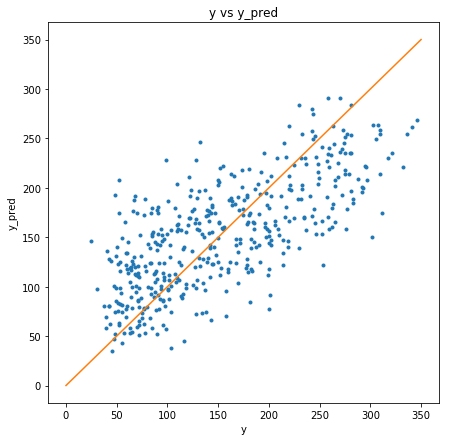

In [9]:
evaluate_model_crossval(df.drop(['Y'], axis=1).values, df['Y'].values)
evaluate_model(df.drop(['Y'], axis=1).values, df['Y'].values)

In [11]:
df['age']

0      0.038076
1     -0.001882
2      0.085299
3     -0.089063
4      0.005383
5     -0.092695
6     -0.045472
7      0.063504
8      0.041708
9     -0.070900
10    -0.096328
11     0.027178
12     0.016281
13     0.005383
14     0.045341
15    -0.052738
16    -0.005515
17     0.070769
18    -0.038207
19    -0.027310
20    -0.049105
21    -0.085430
22    -0.085430
23     0.045341
24    -0.063635
25    -0.067268
26    -0.107226
27    -0.023677
28     0.052606
29     0.067136
         ...   
412    0.074401
413   -0.052738
414    0.081666
415   -0.005515
416   -0.027310
417   -0.052738
418    0.009016
419   -0.020045
420    0.023546
421    0.038076
422   -0.078165
423    0.009016
424    0.001751
425   -0.078165
426    0.030811
427   -0.034575
428    0.048974
429   -0.041840
430   -0.009147
431    0.070769
432    0.009016
433   -0.027310
434    0.016281
435   -0.012780
436   -0.056370
437    0.041708
438   -0.005515
439    0.041708
440   -0.045472
441   -0.045472
Name: age, Length: 442, 

R2: 0.47 (+/- 0.28)
MSE: 2820.53
R2: 0.52


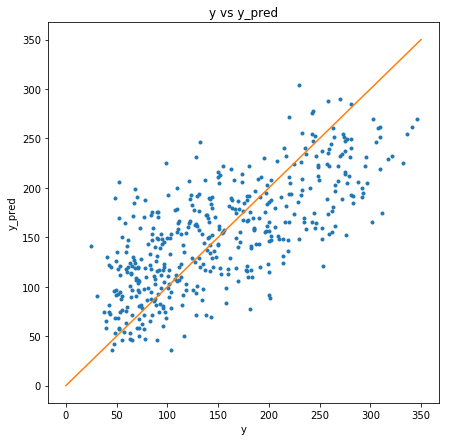

In [13]:
df2 = df.copy()
df2['age'] = np.square(df2['age'])

evaluate_model_crossval(df2.drop(['Y'], axis=1).values, df2['Y'].values)
evaluate_model(df2.drop(['Y'], axis=1).values, df2['Y'].values)

R2: 0.46 (+/- 0.27)
MSE: 0.50
R2: 0.50


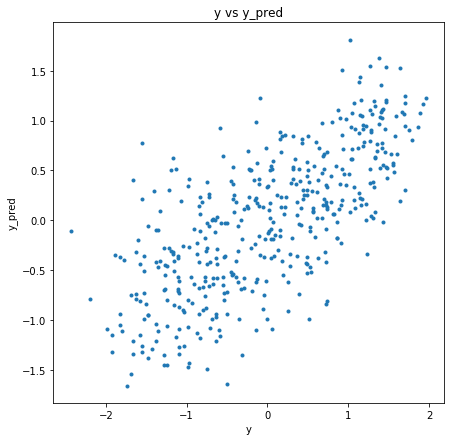

In [22]:
from sklearn.preprocessing import PowerTransformer

df2 = df.copy()
df2['age'] = np.square(df2['age'])
boxcox = PowerTransformer()
x_transformed = boxcox.fit_transform(df2)

evaluate_model_crossval(x_transformed[:,0:-1], x_transformed[:,-1])
evaluate_model(x_transformed[:,0:-1], x_transformed[:,-1])
#x_transformed[:,-1]
#evaluate_model_crossval(x_transformed, df['Y'].values)
#evaluate_model(df.drop(['Y'], axis=1).values, df['Y'].values)